In [1]:
import pandas as pd
import csv
import pickle as pkl
import numpy as np
from fasttext import FastText
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime


In [2]:
model = FastText.load_model('cc.en.300.bin')

In [36]:
class Embeddings:
    def __init__(self, model) -> None:
        self.model = model
    def get_embeddings(self, words):
        return np.array([self.model.get_word_vector(i) for i in words])
    

In [37]:
tags = pkl.load(open('./tags.pkl', 'rb'))

In [38]:
embedding_class = Embeddings(model)
ems = embedding_class.get_embeddings(tags[:100])

In [39]:
anew_dataset = pd.read_csv('./anew.csv')

In [102]:
anew_dict= dict()
words = anew_dataset['term']
valence_ratings = anew_dataset['pleasure']
arousal_ratings = anew_dataset['arousal']
word_embeddings = embedding_class.get_embeddings(words)
word_embedding_dict = dict(zip(words, word_embeddings))
for i in range(len(words)):
    anew_dict[words[i]] = [valence_ratings[i], arousal_ratings[i]]

In [116]:
X = word_embeddings
Y = np.array([anew_dict[i] for i in words])

In [117]:
X = X - X.mean(axis=0)
X = X / X.std(axis=0)

In [118]:

Y = (Y - Y.mean(axis =0))/Y.var(axis = 0)
# SCaling the data -- large loss issues. 

In [119]:
pkl.dump(X, open('X.pkl', 'wb'))
pkl.dump(Y, open('Y.pkl', 'wb'))


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [121]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(X_test, y_test)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [122]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [123]:
device

'cpu'

In [124]:
class NetworkModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(300, 150)
        self.linear_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.Dropout(0.3),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x



In [125]:
train = True
if(train == True):
    model_train = NetworkModel().to(device)
    epochs = 200
    learning_rate = 16e-5
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
    test_loss = []
    train_loss = []
    for i in range(epochs):
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            loss = loss_fn(Y_pred, Y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        # Test Loss
        with torch.no_grad():
            for X, Y in test_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model_train(X.float())
                test_loss_fn = loss_fn(Y_pred, Y.float())
            print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
            test_loss.append(test_loss_fn.item())

Epoch 0, Training Loss: 0.1290062516927719, Test Loss: 0.13710227608680725
Epoch 1, Training Loss: 0.10089712589979172, Test Loss: 0.11155843734741211
Epoch 2, Training Loss: 0.07362452149391174, Test Loss: 0.07605988532304764
Epoch 3, Training Loss: 0.05441739410161972, Test Loss: 0.07027433812618256
Epoch 4, Training Loss: 0.05322641134262085, Test Loss: 0.04640526324510574
Epoch 5, Training Loss: 0.05381857231259346, Test Loss: 0.06877747923135757
Epoch 6, Training Loss: 0.0477137416601181, Test Loss: 0.07220857590436935
Epoch 7, Training Loss: 0.03326361998915672, Test Loss: 0.04868112504482269
Epoch 8, Training Loss: 0.04897337779402733, Test Loss: 0.02619210258126259
Epoch 9, Training Loss: 0.06051981821656227, Test Loss: 0.04445532709360123
Epoch 10, Training Loss: 0.056100402027368546, Test Loss: 0.029059890657663345
Epoch 11, Training Loss: 0.03151316195726395, Test Loss: 0.05752655118703842
Epoch 12, Training Loss: 0.03890936076641083, Test Loss: 0.03596450760960579
Epoch 13,

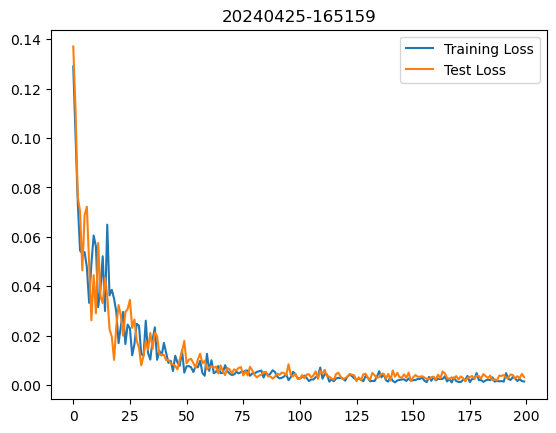

In [126]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
plt.savefig(f'./train_logs/{datestring}.png')